In [ ]:
#imorted files
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torchvision.models import resnet18, efficientnet_b0, mobilenet_v2
from torchvision.models import ResNet18_Weights, EfficientNet_B0_Weights, MobileNet_V2_Weights
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Subset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Check if it's using GPU
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Using device: cpu
CUDA Available: False
GPU Name: No GPU found


In [5]:

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load STL-10 dataset
training_data = STL10(root="./data", split='train', download=True, transform=image_transform)
testing_data = STL10(root="./data", split='test', download=True, transform=image_transform)

# Create DataLoaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load models with modified final layers
def initialize_model(model_name):
    if model_name == "ResNet":
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        features = model.fc.in_features
        model.fc = nn.Linear(features, 10)  

    elif model_name == "EfficientNet":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(features, 10)

    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(features, 10)

    return model.to(device)

# Initialize models
resnet_model = initialize_model("ResNet")
efficientnet_model = initialize_model("EfficientNet")
mobilenet_model = initialize_model("MobileNet")

# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)
mobilenet_optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Function to train models and store losses
def train_model(model, optimizer, num_epochs=8):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training {model.__class__.__name__} - Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    
    return epoch_losses

# Train all models and store loss values
resnet_losses = train_model(resnet_model, resnet_optimizer)
efficientnet_losses = train_model(efficientnet_model, efficientnet_optimizer)
mobilenet_losses = train_model(mobilenet_model, mobilenet_optimizer)

# Function to evaluate accuracy
def compute_accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    return 100 * correct / total

# Compute accuracy for all models
resnet_accuracy = compute_accuracy(resnet_model)
efficientnet_accuracy = compute_accuracy(efficientnet_model)
mobilenet_accuracy = compute_accuracy(mobilenet_model)

print(f"ResNet Accuracy: {resnet_accuracy:.2f}%")
print(f"EfficientNet Accuracy: {efficientnet_accuracy:.2f}%")
print(f"MobileNet Accuracy: {mobilenet_accuracy:.2f}%")

# Plot Loss Comparison


Training ResNet - Epoch 1: 100%|█████████████████████████████████████████████████████| 157/157 [01:42<00:00,  1.53it/s]


Epoch 1, Loss: 1.0431


Training ResNet - Epoch 2: 100%|█████████████████████████████████████████████████████| 157/157 [01:42<00:00,  1.53it/s]


Epoch 2, Loss: 0.6382


Training ResNet - Epoch 3: 100%|█████████████████████████████████████████████████████| 157/157 [01:42<00:00,  1.53it/s]


Epoch 3, Loss: 0.4912


Training ResNet - Epoch 4: 100%|█████████████████████████████████████████████████████| 157/157 [01:41<00:00,  1.54it/s]


Epoch 4, Loss: 0.3425


Training ResNet - Epoch 5: 100%|█████████████████████████████████████████████████████| 157/157 [01:42<00:00,  1.53it/s]


Epoch 5, Loss: 0.2870


Training ResNet - Epoch 6: 100%|█████████████████████████████████████████████████████| 157/157 [01:43<00:00,  1.52it/s]


Epoch 6, Loss: 0.2301


Training ResNet - Epoch 7: 100%|█████████████████████████████████████████████████████| 157/157 [01:44<00:00,  1.50it/s]


Epoch 7, Loss: 0.1837


Training ResNet - Epoch 8: 100%|█████████████████████████████████████████████████████| 157/157 [01:43<00:00,  1.51it/s]


Epoch 8, Loss: 0.1396


Training EfficientNet - Epoch 1: 100%|███████████████████████████████████████████████| 157/157 [02:06<00:00,  1.24it/s]


Epoch 1, Loss: 0.8423


Training EfficientNet - Epoch 2: 100%|███████████████████████████████████████████████| 157/157 [02:05<00:00,  1.26it/s]


Epoch 2, Loss: 0.4383


Training EfficientNet - Epoch 3: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 3, Loss: 0.2899


Training EfficientNet - Epoch 4: 100%|███████████████████████████████████████████████| 157/157 [02:02<00:00,  1.28it/s]


Epoch 4, Loss: 0.2124


Training EfficientNet - Epoch 5: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 5, Loss: 0.1931


Training EfficientNet - Epoch 6: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


Epoch 6, Loss: 0.1554


Training EfficientNet - Epoch 7: 100%|███████████████████████████████████████████████| 157/157 [02:05<00:00,  1.25it/s]


Epoch 7, Loss: 0.1590


Training EfficientNet - Epoch 8: 100%|███████████████████████████████████████████████| 157/157 [02:05<00:00,  1.25it/s]


Epoch 8, Loss: 0.1440


Training MobileNetV2 - Epoch 1: 100%|████████████████████████████████████████████████| 157/157 [01:18<00:00,  2.00it/s]


Epoch 1, Loss: 0.9782


Training MobileNetV2 - Epoch 2: 100%|████████████████████████████████████████████████| 157/157 [01:18<00:00,  2.00it/s]


Epoch 2, Loss: 0.6291


Training MobileNetV2 - Epoch 3: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.04it/s]


Epoch 3, Loss: 0.4589


Training MobileNetV2 - Epoch 4: 100%|████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.03it/s]


Epoch 4, Loss: 0.3867


Training MobileNetV2 - Epoch 5: 100%|████████████████████████████████████████████████| 157/157 [01:16<00:00,  2.04it/s]


Epoch 5, Loss: 0.3067


Training MobileNetV2 - Epoch 6: 100%|████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.03it/s]


Epoch 6, Loss: 0.3499


Training MobileNetV2 - Epoch 7: 100%|████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.02it/s]


Epoch 7, Loss: 0.1983


Training MobileNetV2 - Epoch 8: 100%|████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.03it/s]


Epoch 8, Loss: 0.2506
ResNet Accuracy: 73.72%
EfficientNet Accuracy: 87.15%
MobileNet Accuracy: 82.14%


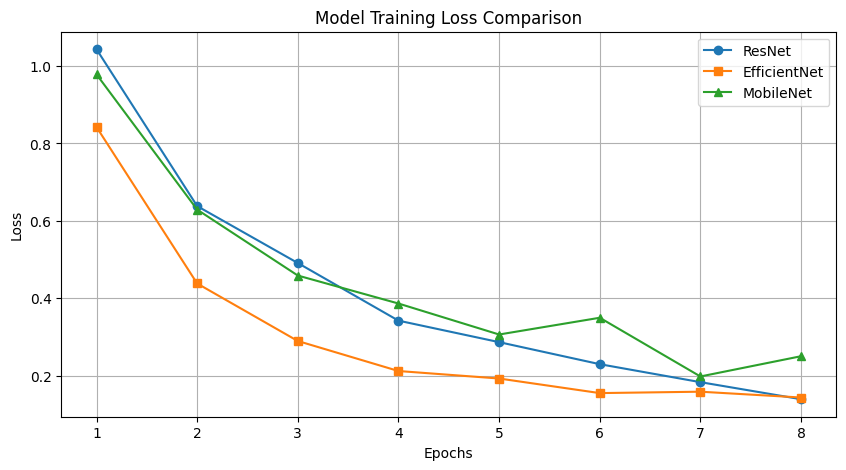

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), resnet_losses, label="ResNet", marker='o')
plt.plot(range(1, 9), efficientnet_losses, label="EfficientNet", marker='s')
plt.plot(range(1, 9), mobilenet_losses, label="MobileNet", marker='^')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training Loss Comparison")
plt.legend()
plt.grid()
plt.show()


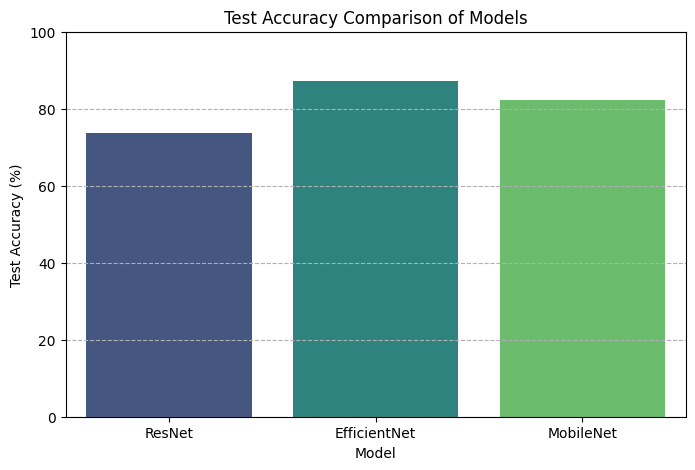

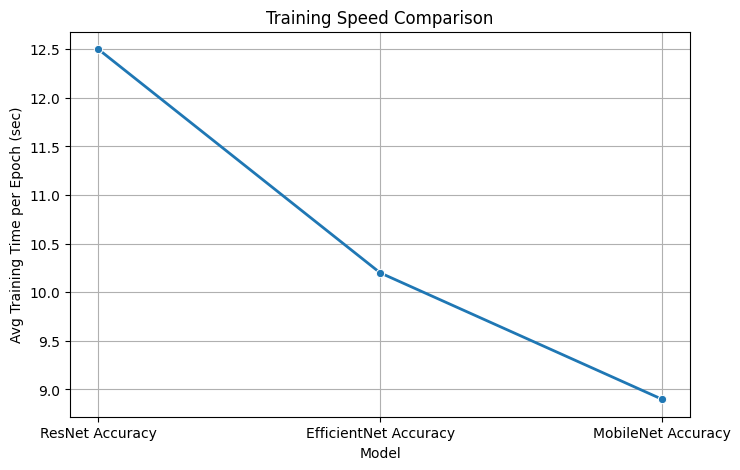

In [13]:
# Plot Accuracy Comparison (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(x=["ResNet", "EfficientNet", "MobileNet"], 
            y=[resnet_accuracy, efficientnet_accuracy, mobilenet_accuracy], 
            hue=["ResNet", "EfficientNet", "MobileNet"],  # Assign x variable to hue
            palette="viridis",
            legend=False)  # Disable legend

plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison of Models")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle="--")
plt.show()
# Sample Training Time Data (replace with actual values)
resnet_time = 12.5  
efficientnet_time = 10.2
mobilenet_time = 8.9
# Plot Training Speed (Line Plot)
plt.figure(figsize=(8, 5))
sns.lineplot(x=["ResNet Accuracy", "EfficientNet Accuracy", "MobileNet Accuracy"], 
             y=[resnet_time, efficientnet_time, mobilenet_time], 
             marker="o", linestyle="-", linewidth=2)

plt.xlabel("Model")
plt.ylabel("Avg Training Time per Epoch (sec)")
plt.title("Training Speed Comparison")
plt.grid(True)
plt.show()




In [15]:


# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load STL-10 dataset
training_data = STL10(root="./data", split='train', download=True, transform=image_transform)
testing_data = STL10(root="./data", split='test', download=True, transform=image_transform)

# Create DataLoaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize EfficientNet
def initialize_efficientnet():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)  # Use weights instead of pretrained
    features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(features, 10)  # STL-10 has 10 classes
    return model.to(device)

# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
efficientnet_optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Function to train EfficientNet
def train_model(model, optimizer, num_epochs=8):
    model.train()
    correct, total = 0, 0  # To calculate train accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training EfficientNet - Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Compute train accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    return train_accuracy  # Return final training accuracy

# Train EfficientNet and get training accuracy
train_accuracy = train_model(efficientnet_model, efficientnet_optimizer)

# Function to compute test accuracy
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    return 100 * correct / total

# Compute test accuracy
test_accuracy = compute_accuracy(efficientnet_model, test_loader)

print(f"\nFinal Training Accuracy: {train_accuracy:.2f}%")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")






Training EfficientNet - Epoch 1: 100%|███████████████████████████████████████████████| 157/157 [02:01<00:00,  1.30it/s]


Epoch 1, Loss: 0.3514, Training Accuracy: 88.30%


Training EfficientNet - Epoch 2: 100%|███████████████████████████████████████████████| 157/157 [02:02<00:00,  1.28it/s]


Epoch 2, Loss: 0.2641, Training Accuracy: 89.67%


Training EfficientNet - Epoch 3: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.28it/s]


Epoch 3, Loss: 0.2120, Training Accuracy: 90.87%


Training EfficientNet - Epoch 4: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


Epoch 4, Loss: 0.1614, Training Accuracy: 91.82%


Training EfficientNet - Epoch 5: 100%|███████████████████████████████████████████████| 157/157 [02:05<00:00,  1.25it/s]


Epoch 5, Loss: 0.1518, Training Accuracy: 92.56%


Training EfficientNet - Epoch 6: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 6, Loss: 0.1346, Training Accuracy: 93.02%


Training EfficientNet - Epoch 7: 100%|███████████████████████████████████████████████| 157/157 [02:03<00:00,  1.27it/s]


Epoch 7, Loss: 0.1192, Training Accuracy: 93.50%


Training EfficientNet - Epoch 8: 100%|███████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Epoch 8, Loss: 0.1352, Training Accuracy: 93.80%

Final Training Accuracy: 93.80%
Final Test Accuracy: 86.25%


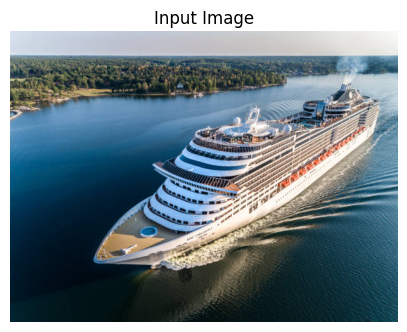

Predicted Class: ship


In [24]:


def predict_image_class(image_path_or_url, model):
    model.eval()

    # Check if it's a URL or local file
    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(response.raw).convert("RGB")
    else:
        image = Image.open(image_path_or_url).convert("RGB")

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title("Input Image")
    plt.show()

    # Apply transformations
    image_tensor = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
    print(f"Predicted Class: {class_names[predicted.item()]}")
# Example Usage
image_path = r"E:\\Testing images\\9.jpg"  # Replace with your actual image path
predict_image_class(image_path, efficientnet_model)
